# **会計不正リスクスクリーニングツール (Financial Fraud Risk Screening Tool)**
**Version:** 1.0.0 **Author:** CPA Developer (Certified Public Accountant / Statistical Analyst)



**1.** **概要 (Executive Summary)**

本ツールは、EDINET（金融商品取引法に基づく有価証券報告書等の開示書類に関する電子開示システム）のAPIを利用し、上場企業の「財務数値（定量的リスク）」と「ガバナンス兆候（定性的リスク）」を自動収集・解析する簡易スクリーニングモデルです。公認会計士の知見に基づき、Dechow F-score（粉飾決算検知モデル）やSloan Ratio（発生高の質分析）といった指標を実装しています。

**2.** **特徴と実装のポイント (Key Features)**

**XBRL解析の高度化:** J-GAAP（日本基準）、IFRS、US-GAAPのタグの「揺らぎ」を吸収する独自のマッピングロジック（Priority Map）を実装し、会計基準が異なる企業間の比較可能性を担保。

**定性情報の統合:** 財務数値だけでなく、Google News RSSを用いて「CFO/経理担当役員の辞任」等のガバナンスリスク情報をリアルタイムに収集・統合。

**非同期処理による高速化:** asyncio / aiohttp を活用し、APIレート制限（Semaphore）を遵守しつつ、複数企業のデータを効率的に取得。


**3.** **分析ロジック (Methodology)**

本ツールでは以下の主要指標を用いてリスク判定を行います。

**Dechow F-score:** 発生高（Accruals）の質と財務パフォーマンスの変化から、不正会計の確率を予測するモデル。

**Sloan Ratio:** 純利益と営業キャッシュフローの乖離（Accruals）を資産規模で標準化し、利益の質を評価。

**回転期間分析:** 売上債権・棚卸資産・仕入債務の回転期間の「前期差」を計算し、異常な長期化（滞留在庫や架空売上の兆候）を検知。

**ガバナンスチェック:** 監査法人の規模（Big4か否か）や、決算発表の遅延日数等をスコアリング。

In [ ]:
# [1] 必要なライブラリのインストール
# RSS解析(feedparser)、非同期通信(aiohttp)、スクレイピング(bs4)、XBRL解析(lxml)を使用
!pip install feedparser python-dotenv aiohttp beautifulsoup4 pandas nest_asyncio lxml

**4. 設定と分類タクソノミ (Configuration)**

ここでは、分析対象となる勘定科目の優先順位定義（PRIORITY_MAP_SINGLE）や、ニュース検索用キーワード、業種定義を行っています。 特にXBRLタグの定義においては、各社が採用する会計基準（日本基準、米国基準、国際会計基準）によってタグ名が異なるため、これらを正規化するための辞書を構築しています。

In [65]:
# [2] インポート・初期設定・メタ情報
"""
Simple Financial Fraud Detection Tool
-----------------------------------
公認会計士の知見を活かし、EDINETデータから不正会計リスクを検知するツール。
非同期処理による高速化と、会計基準の揺らぎを吸収するパース処理を実装。
"""
from __future__ import annotations

__title__ = 'Simple Financial Fraud Detection Tool'
__version__ = '1.0.0'
__date__ = '2025-01-22'
__author__ = 'CPA Developer'
__license__ = 'MIT'
__status__ = 'Production'

import os
import sys
import pandas as pd
import io
import zipfile
import math
import numpy as np
from bs4 import BeautifulSoup
import time
from datetime import datetime, timedelta
import urllib.parse
import re
import asyncio
import aiohttp
import logging
from typing import List, Dict, Optional, Tuple, Any, Union
import feedparser
from dotenv import load_dotenv
import warnings
import html
import nest_asyncio
import getpass

# Colab環境でのイベントループ競合を防ぐ設定
nest_asyncio.apply()

# 環境設定・ログ設定
load_dotenv()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# ログフォーマットの設定（時刻とログレベルを表示）
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
# @title
# 処理フロー図作成
!sudo apt-get update
!sudo apt-get install -y graphviz
!pip install graphviz


処理フロー図を描画します（Graphviz使用）:


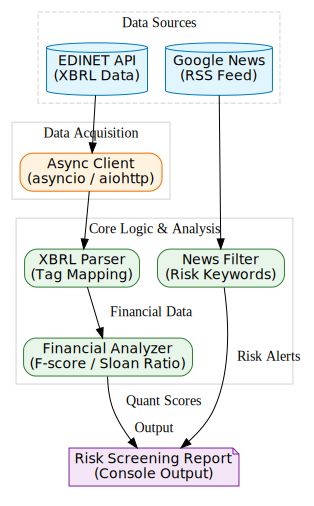

In [3]:

from graphviz import Digraph
from IPython.display import display

# 図の定義
dot = Digraph('SystemFlow', comment='Financial Fraud Detection Flow')

# 全体の設定（TB=Top to Bottom: 上から下へ）
dot.attr(rankdir='TB')
dot.attr('node', fontname='Gothic', shape='box', style='filled, rounded')

# 1. データソース層 (Data Sources)
with dot.subgraph(name='cluster_0') as c:
    c.attr(label='Data Sources', color='lightgrey', style='dashed')
    c.node('API', 'EDINET API\n(XBRL Data)', shape='cylinder', fillcolor='#E1F5FE', color='#0277BD')
    c.node('RSS', 'Google News\n(RSS Feed)', shape='cylinder', fillcolor='#E1F5FE', color='#0277BD')

# 2. データ取得層 (Acquisition)
with dot.subgraph(name='cluster_1') as c:
    c.attr(label='Data Acquisition', color='lightgrey')
    # 【修正箇所】shape='component' を shape='box' に変更しました
    c.node('Async', 'Async Client\n(asyncio / aiohttp)', shape='box', fillcolor='#FFF3E0', color='#EF6C00')

# 3. 分析ロジック層 (Processing)
with dot.subgraph(name='cluster_2') as c:
    c.attr(label='Core Logic & Analysis', color='lightgrey')
    c.node('Parser', 'XBRL Parser\n(Tag Mapping)', fillcolor='#E8F5E9', color='#2E7D32')
    c.node('Filter', 'News Filter\n(Risk Keywords)', fillcolor='#E8F5E9', color='#2E7D32')
    c.node('Analyzer', 'Financial Analyzer\n(F-score / Sloan Ratio)', fillcolor='#E8F5E9', color='#2E7D32')

# 4. 出力層 (Output)
with dot.subgraph(name='cluster_3') as c:
    c.attr(label='Output', color='white')
    c.node('Report', 'Risk Screening Report\n(Console Output)', shape='note', fillcolor='#F3E5F5', color='#7B1FA2')

# 矢印（フロー）の定義
dot.edge('API', 'Async')
dot.edge('Async', 'Parser')
dot.edge('Parser', 'Analyzer', label=' Financial Data')
dot.edge('RSS', 'Filter')
dot.edge('Analyzer', 'Report', label=' Quant Scores')
dot.edge('Filter', 'Report', label=' Risk Alerts')

# 描画
print("処理フロー図を描画します（Graphviz使用）:")
display(dot)

**5. データ取得レイヤー (Data Acquisition Layer)**

外部APIとの通信を担うクラス群です。

NewsClient: 経営幹部の異動情報をRSSから取得し、リスクワード（「更迭」「一身上」等）でフィルタリングします。

JpxClient: 日本取引所グループ(JPX)から業種データを取得し、製造業・金融業などのセクター判定に利用します。

EdinetClient: EDINET API v2への接続を管理します。asyncio.Semaphoreを用いて同時接続数を制御し、サーバー負荷を考慮しています。

In [67]:
# [3] Configクラス (定数・設定管理)
class Config:
    """
    アプリケーション全体の定数・設定を一元管理するクラス。
    会計基準の差異や、ニュース検索クエリの定義を含む。
    """

    # --- News API Settings ---
    NEWS_ROLES = "CFO OR 最高財務責任者 OR 財務 OR 経理 OR 役員"
    NEWS_ACTIONS = "辞任 OR 退任 OR 交代 OR 辞職 OR 更迭 OR 解任"
    NEWS_RISK_KEYWORDS = ["更迭", "一身上", "突然", "不正", "処分", "不明朗", "交代", "異動"]
    NEWS_SHORT_TERM_KEYWORDS = ["短期間", "わずか", "就任直後", "ヶ月", "スピード"]

    # --- JPX Settings ---
    JPX_URL = "https://www.jpx.co.jp/markets/statistics-equities/misc/01.html"

    # --- Financial / Sector Settings ---
    FINANCIAL_SECTORS = ['銀行業', '証券、商品先物取引業', '保険業', 'その他金融業']
    BIG4_KEYWORDS = ["トーマツ", "あずさ", "新日本", "PwC", "ＰｗＣ", "あらた", "Deloitte", "EY", "KPMG"]
    MANUFACTURING_SECTORS = [
        '水産・農林業', '鉱業', '建設業', '食料品', '繊維製品', 'パルプ・紙', '化学',
        '医薬品', '石油・石炭製品', 'ゴム製品', 'ガラス・土石製品', '鉄鋼', '非鉄金属',
        '金属製品', '機械', '電気機器', '輸送用機器', '精密機器', 'その他製品'
    ]

    # --- XBRL Parsing Priority Map ---
    PRIORITY_MAP_SINGLE = {
        'Sales': [
            'OrdinaryIncomeSummaryOfBusinessResults',           # J-GAAP
            'RevenueIFRSSummaryOfBusinessResults',              # IFRS
            'RevenuesUSGAAPSummaryOfBusinessResults',           # US-GAAP
            'NetSalesSummaryOfBusinessResults',
            'SalesAndFinancialServicesRevenueIFRS',
            'TotalNetRevenuesIFRS', 'SalesRevenuesIFRS', 'OperatingRevenuesIFRSKeyFinancialData',
            'OrdinaryRevenue', 'OperatingRevenue1', 'Revenue', 'NetSales', 'Revenues'
        ],
        'OpIncome': [
            'OperatingProfitLossIFRSSummaryOfBusinessResults',  # IFRS
            'OperatingIncomeLossSummaryOfBusinessResults',      # US-GAAP
            'OrdinaryIncomeLossSummaryOfBusinessResults',       # J-GAAP
            'OrdinaryProfit', 'OrdinaryIncome', 'OrdinaryIncomeLoss',
            'OperatingProfit', 'OperatingIncome',
            'OperatingProfitLossIFRS', 'ProfitLossFromOperatingActivities',
            'ProfitLossBeforeTaxIFRSSummaryOfBusinessResults',
            'ProfitLossBeforeTaxUSGAAPSummaryOfBusinessResults',
            'ProfitLossBeforeTaxIFRS'
        ],
        'NetIncome': [
            'ProfitLossAttributableToOwnersOfParentIFRSSummaryOfBusinessResults',
            'NetIncomeLossAttributableToOwnersOfParentUSGAAPSummaryOfBusinessResults',
            'ProfitLossAttributableToOwnersOfParentSummaryOfBusinessResults',
            'ProfitLossAttributableToOwnersOfParent', 'NetIncome', 'ProfitLoss'
        ],
        'TotalAssets': [
            'TotalAssetsIFRSSummaryOfBusinessResults',
            'TotalAssetsUSGAAPSummaryOfBusinessResults',
            'TotalAssetsSummaryOfBusinessResults',
            'AssetsIFRS', 'Assets', 'TotalAssets'
        ],
        'NetAssets': [
            'NetAssetsSummaryOfBusinessResults', 'EquityIFRS', 'TotalEquity', 'NetAssets'
        ],
        'OpCashFlow': [
            'NetCashProvidedByUsedInOperatingActivitiesSummaryOfBusinessResults',
            'NetCashProvidedByUsedInOperatingActivities',
            'CashFlowsFromUsedInOperatingActivitiesIFRSSummaryOfBusinessResults',
            'CashFlowsFromUsedInOperatingActivitiesUSGAAPSummaryOfBusinessResults'
        ],
        'CurrentAssets': ['CurrentAssets', 'AssetsCurrent', 'CurrentAssetsIFRS'],
        'CurrentLiabilities': ['CurrentLiabilities', 'LiabilitiesCurrent'],
        'RetainedEarnings': ['RetainedEarnings', 'RetainedEarningsIFRS'],
        'CashAndEquivalents': ['CashAndCashEquivalents', 'CashAndDeposits'],
        'PPE': ['PropertyPlantAndEquipment', 'PropertyPlantAndEquipmentNet']
    }

    # --- XBRL Summation Groups ---
    XBRL_TAG_GROUPS = {
        'Receivables': [
            'AccountsReceivableTrade', 'NotesReceivableTrade', 'TradeAndOtherReceivables',
            'TradeAndOtherReceivables3CAIFRS', 'TradeAndOtherReceivablesCAIFRS',
            'TradeReceivablesOtherReceivablesAndContractAssetsCAIFRS',
            'ReceivablesRelatedToFinancialServicesCAIFRS', 'NotesAndAccountsReceivableTradeAndContractAssets',
            # IFRS/Financials
            'TradeReceivables2AssetsIFRS', 'LeaseReceivablesCA', 'AccountsReceivableInstallmentSalesCALEA',
            'OperatingLoansCA', 'LoansInCreditCardBusinessAssetsIFRS', 'LoansInBankingBusinessAssetsIFRS',
            'InstallmentLoans', 'NetInvestmentInLeases', 'LoansToCustomers', 'FinanceLeaseReceivables',
            'InvestmentInDirectFinancingLeases', 'OperatingLoans', 'LeaseInvestmentAssets',
            'Loans', 'InstallmentReceivables'
        ],
        'Inventory': [
            'Inventories', 'MerchandiseAndFinishedGoods', 'WorkInProcess',
            'InventoriesCAIFRS', 'MerchandiseCAIFRS', 'FinishedGoodsCAIFRS', 'RawMaterialsAndSuppliesCAIFRS',
            'InventoriesIFRS', 'InventoriesAssetsIFRS', 'RealEstateForSale', 'RealEstateUnderDevelopment',
            'RealEstateForSaleInProcess', 'OperationalInvestmentSecurities',
            'FinancialAssetsForTheSecuritiesBusinessAssetsIFRS',
            # ORIX / US GAAP Specific (Real Estate & Trading ONLY - Excluded Fixed Assets)
            'RealEstateHeldForSale', 'RealEstateUnderDevelopment', 'AdvancesForRealEstate',
            'TradingSecurities', 'MarketableSecurities', 'Merchandise'
        ],
        'Payables': [
            'AccountsPayableTrade', 'NotesPayableTrade', 'TradeAndOtherPayables',
            'TradeAndOtherPayables3CLIFRS', 'TradeAndOtherPayablesCLIFRS',
            'AccountsPayableTradeLiabilitiesIFRS', 'NotesAndAccountsPayableTrade',
            'FinancialLiabilitiesForSecuritiesBusinessLiabilitiesIFRS'
        ]
    }

In [68]:
# [4] 設定取得関数 (Secrets/Env/Input対応)
def get_config() -> tuple[str, list[str]]:
    """
    実行環境に応じて適切な方法でAPIキーと対象企業コードを取得する。

    Returns:
        tuple[str, list[str]]: (APIキー, 企業コードのリスト)

    Priority:
        1. Google Colab Secrets (セキュリティ推奨)
        2. 環境変数 (.envなど)
        3. 手入力 (インタラクティブモード)
    """
    api_key = None

    # 1. Google Colab Secrets からの取得を試みる
    try:
        from google.colab import userdata
        api_key = userdata.get('EDINET_API_KEY')
        logger.info("Google Colab SecretsからAPIキーを読み込みました。")
    except (ImportError, Exception):
        pass # Colab以外環境、またはキー未設定の場合はスルー

    # 2. 環境変数から取得を試みる (ローカル開発用)
    if not api_key:
        api_key = os.getenv("EDINET_API_KEY")
        if api_key:
            logger.info("環境変数からAPIキーを読み込みました。")

    # 3. 手入力を求める (最終手段)
    if not api_key:
        print("APIキーが見つかりませんでした。")
        api_key = getpass.getpass('EDINET API Keyを入力してください: ')

    if not api_key:
        raise ValueError("API Key was not entered.")

    # 企業コードの取得
    env_codes = None
    # Colab Secretsから企業コードも取れるようにする場合
    try:
        from google.colab import userdata
        env_codes = userdata.get('TARGET_CODES')
    except: pass

    if not env_codes:
        env_codes = os.getenv("TARGET_CODES")

    if env_codes:
        code_input = env_codes
        logger.info("保存された設定から企業コードを読み込みました。")
    else:
        print(f"\n[{__title__} v{__version__}]")
        print("分析したい企業コードを入力してください（最大10社、全角/半角スペース区切り）")
        print(f"銘柄コード検索: {Config.JPX_URL}")
        print("例: 6758 9984 8306 (Enterで決定)")
        code_input = input('Company Codes: ')

    codes = [c for c in re.split(r'[ 　]+', code_input.strip()) if c][:10]
    if not codes:
        raise ValueError("Company Code was not entered.")

    return api_key, codes

In [69]:
# [5] ニュース取得機能 (NewsClient)
class NewsClient:
    """
    Google News RSSを利用してCFO/役員の辞任情報を検索するクラス。
    ガバナンスリスクの初期的な検知を行う。
    """

    def __init__(self):
        self.base_url = "https://news.google.com/rss/search"
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

    def check_cfo_news(self, company_name: str) -> tuple[list[dict[str, str]], str]:
        """
        特定企業のCFO/財務担当役員に関するネガティブニュースを検索する。

        Args:
            company_name (str): 検索対象の企業名

        Returns:
            tuple: (ニュースリスト, 総合判定コメント)
        """
        # Configから検索クエリを構築
        query = f'"{company_name}" ({Config.NEWS_ROLES}) ({Config.NEWS_ACTIONS})'
        params = {"q": query, "hl": "ja", "gl": "JP", "ceid": "JP:ja"}
        rss_url = f"{self.base_url}?{urllib.parse.urlencode(params)}"

        try:
            feed = feedparser.parse(rss_url, request_headers=self.headers)
            if hasattr(feed, 'status') and feed.status != 200:
                logger.warning(f"News feed status error: {feed.status} for {company_name}")
                return [], "⚠️ 取得失敗 (接続エラー)"

            news_results = []
            overall_verdict = "✅ 正常 (関連ニュースなし)"

            for entry in feed.entries[:5]:
                title = entry.title
                status = "INFO"
                # 短期間での辞任など、リスクワードをチェック
                if any(k in title for k in Config.NEWS_SHORT_TERM_KEYWORDS):
                    status = "🚨 OUT (短期間)"
                    overall_verdict = "🚨 OUT (CFO/役員の短期間辞任あり)"
                elif any(k in title for k in Config.NEWS_RISK_KEYWORDS):
                    status = "⚠️ 警戒"
                    if "OUT" not in overall_verdict: overall_verdict = "⚠️ 警戒 (不穏な辞任)"

                news_results.append({"title": title, "date": entry.published, "status": status})
            return news_results, overall_verdict
        except Exception as e:
            logger.error(f"News API Error for {company_name}: {e}")
            return [], "⚠️ 取得失敗 (API/Networkエラー)"

In [70]:
# [6] 業種データ取得機能 (JpxClient)
class JpxClient:
    """
    JPX公式サイトから業種データ(Excel)を取得し、企業コードと紐付けるクラス。
    製造業/非製造業の判定や、金融業の除外判定に使用する。
    """

    def __init__(self):
        self.jpx_url = Config.JPX_URL
        self.base_host = "https://www.jpx.co.jp"
        self.sector_map = {}

    async def fetch_sector_data(self):
        """JPXから業種一覧をダウンロードし、メモリ上にマッピングを作成する"""
        print("JPX公式サイトから最新の業種データを取得中...", end="")
        try:
            async with aiohttp.ClientSession() as session:
                async with session.get(self.jpx_url) as res:
                    if res.status != 200:
                        logger.warning(f"JPX access failed. Status: {res.status}")
                        return
                    text = await res.text()
            soup = BeautifulSoup(text, 'html.parser')
            link = soup.find('a', href=re.compile(r'data_j\.xls'))
            if not link:
                logger.warning("JPX excel link not found.")
                return
            df = pd.read_excel(self.base_host + link['href'])
            for _, row in df.iterrows():
                code = str(row.get('コード', ''))[:4]
                sector = row.get('33業種区分', '不明')
                if code: self.sector_map[code] = sector.strip()
            print(" 完了")
        except Exception as e:
            logger.error(f"JPX fetch sector data failed: {e}")
            print(" 失敗")

    def get_sector(self, code: str) -> str:
        return self.sector_map.get(code[:4], "不明")

In [71]:
# [7] EDINET API連携機能 (EdinetClient)
class EdinetClient:
    """
    EDINET API v2を利用して有価証券報告書のメタデータとXBRLを取得するクラス。
    APIレート制限(Semaphore)を考慮した設計。
    """

    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://api.edinet-fsa.go.jp/api/v2"
        self.semaphore = asyncio.Semaphore(5) # 同時リクエスト制限
        self.doc_cache = {}

    async def prefetch_metadata(self, session: aiohttp.ClientSession, target_codes: List[str]):
        """過去2年分の提出書類リストをスキャンし、対象企業の最新の有報を特定する"""
        print(f"\nAPIアクセス: メタデータスキャン中（過去2年）...")
        dates = [datetime.now().date() - timedelta(days=i) for i in range(365 * 2)]

        async def fetch_date(date_obj):
            url = f"{self.base_url}/documents.json"
            params = {"date": date_obj.strftime("%Y-%m-%d"), "type": 2, "Subscription-Key": self.api_key}
            try:
                async with self.semaphore:
                    async with session.get(url, params=params, timeout=15) as res:
                        if res.status != 200: return
                        data = await res.json()
                        for item in data.get('results', []):
                            sec_code = str(item.get('secCode', ''))[:4]
                            # docTypeCode '120' は有価証券報告書
                            if sec_code in target_codes and item.get('docTypeCode') == '120':
                                if sec_code not in self.doc_cache: self.doc_cache[sec_code] = []
                                self.doc_cache[sec_code].append(item)
            except Exception as e:
                logger.error(f"Metadata fetch failed for {date_obj}: {e}")

        tasks = [fetch_date(d) for d in dates]
        # サーバー負荷軽減のためバッチ処理
        for i in range(0, len(tasks), 50):
            await asyncio.gather(*tasks[i:i+50])
            print(f"\r スキャン進捗: {min(i + 50, len(tasks))}/{len(tasks)} 日完了", end="")
        print("\n メタデータ取得完了")

    async def get_target_document(self, session: aiohttp.ClientSession, sec_code_prefix: str) -> Optional[Dict[str, Any]]:
        """特定企業の最新の有価証券報告書メタデータを取得"""
        docs = self.doc_cache.get(sec_code_prefix)
        if not docs: return None
        # 提出日時が新しい順にソート
        docs.sort(key=lambda x: x.get('submitDateTime', ''), reverse=True)
        return docs[0]

    async def fetch_xbrl_zip(self, session: aiohttp.ClientSession, doc_id: str) -> Optional[bytes]:
        """指定されたドキュメントIDのXBRLデータ(ZIP)をダウンロード"""
        url = f"{self.base_url}/documents/{doc_id}"
        params = {"type": 1, "Subscription-Key": self.api_key}
        try:
            async with self.semaphore:
                async with session.get(url, params=params, timeout=60) as res:
                    return await res.read() if res.status == 200 else None
        except Exception as e:
            logger.error(f"XBRL Zip download failed for {doc_id}: {e}")
            return None

**6. 解析・分析コアロジック (Core Logic)**

取得した生データを意味のある情報に変換する中核部分です。

**6.1 XBRL Parser (XbrlParser)**

ZIP形式で提供されるXBRLファイルをメモリ上で展開し、BeautifulSoupを用いてパースします。 _merge_financials メソッドにおいて、前述のPriority Mapに基づき、最も適切なタグの値を採用します。また、単一のタグだけでなく、XBRL_TAG_GROUPS に定義された「内訳タグの合算」処理も行い、情報の欠落を防いでいます。

**6.2 Financial Analyzer (FinancialAnalyzer)**

抽出されたデータに対し、以下の会計・統計的チェックを実行します。

**Big Bath Check:** 総資産に対する巨額損失の計上（V字回復演出の予兆）有無。

**Dechow F-score Check:** アクルーアルの質に基づく粉飾リスクの確率計算。

**Late Filing Check:** 決算日から提出日までのリードタイム分析。

In [72]:
# [8] XBRL解析機能 (XbrlParser)
class XbrlParser:
    """
    XBRLファイルを解析し、財務数値とガバナンス情報を抽出するクラス。
    複数のXBRLファイルを統合して解析し、情報の網羅性を高める。
    """

    def parse_data(self, zip_bytes: bytes) -> tuple[pd.DataFrame | None, dict[str, Any] | None]:
        if not zip_bytes: return None, None
        try:
            with zipfile.ZipFile(io.BytesIO(zip_bytes)) as z:
                # PublicDocフォルダ内の全XBRLファイルを対象とする
                xbrl_files = [f for f in z.namelist() if f.endswith('.xbrl') and 'PublicDoc' in f]
                if not xbrl_files: return None, None

                # 統合データの初期化
                priority_map_single = Config.PRIORITY_MAP_SINGLE
                df_combined = pd.DataFrame(index=list(priority_map_single.keys()) + ['Receivables', 'Inventory', 'Payables'],
                                           columns=['Current', 'Previous'], dtype='float64').fillna(0.0)

                gov_info_combined = {'Auditor': '不明', 'PeriodEnd': None, 'Standard': 'Japan GAAP', 'isConsolidated': True, 'Industry': 'General',
                                     'related_party_hits': 0, 'related_party_amount': 0.0}

                # 1. First Pass: Metadata Extraction (DEI)
                for filename in xbrl_files:
                    with z.open(filename) as f:
                        soup = BeautifulSoup(f.read().decode('utf-8', errors='replace'), 'lxml-xml')
                        info = self._extract_dei_and_audit_info(soup)
                        if info['PeriodEnd']: gov_info_combined['PeriodEnd'] = info['PeriodEnd']
                        if info['Auditor'] != '不明': gov_info_combined['Auditor'] = info['Auditor']
                        if info['Standard'] != 'Japan GAAP': gov_info_combined['Standard'] = info['Standard']
                        if gov_info_combined['PeriodEnd'] and gov_info_combined['Auditor'] != '不明': break

                seen_group_tags = set()
                current_priorities = {}
                for cat in priority_map_single.keys():
                    for per in ['Current', 'Previous']:
                        current_priorities[(cat, per)] = float('inf')

                # 2. Second Pass: Data Extraction
                for filename in xbrl_files:
                    with z.open(filename) as f:
                        content = f.read().decode('utf-8', errors='replace')
                        soup = BeautifulSoup(content, 'lxml-xml')

                        target_date = gov_info_combined.get('PeriodEnd')
                        if not target_date:
                             target_date = self._infer_period_end(soup)
                             if target_date and not gov_info_combined['PeriodEnd']:
                                 gov_info_combined['PeriodEnd'] = target_date

                        ctx_map = self._map_contexts_strict(soup, target_date)
                        self._merge_financials(soup, ctx_map, df_combined, seen_group_tags, current_priorities)

                        gov_info_combined['related_party_hits'] += str(soup).count("関連当事者")
                        gov_info_combined['related_party_amount'] += self._extract_related_party_amounts(soup)

                return df_combined, gov_info_combined
        except Exception as e:
            logger.error(f"XBRL Parsing Error: {e}")
            return None, None

    def _infer_period_end(self, soup: BeautifulSoup) -> str | None:
        """DEIから日付が取れない場合の救済策"""
        dates = []
        for ctx in soup.find_all(re.compile(r'.*context$')):
            period = ctx.find(re.compile(r'.*period$'))
            if period:
                date_tag = period.find(re.compile(r'.*(instant|endDate)$'))
                if date_tag: dates.append(date_tag.text.strip())
        return max(dates) if dates else None

    def _extract_dei_and_audit_info(self, soup: BeautifulSoup) -> Dict[str, Any]:
        """DEI(文書情報)から監査法人名や会計基準を抽出する (Robust Version)"""
        info = {'Auditor': '不明', 'PeriodEnd': None, 'Standard': 'Japan GAAP', 'isConsolidated': True}

        def clean_auditor_name(raw_text: str) -> str:
            if not raw_text: return '不明'
            text = BeautifulSoup(raw_text, "html.parser").get_text()
            text = html.unescape(text)
            text = re.sub(r'[\s\u3000]+', ' ', text).strip()
            text = re.sub(r'(?:監査法人|会計監査人)の名称[:：]?', '', text)
            text = re.sub(r'当社の監査公認会計士等は[、,]', '', text)
            text = re.sub(r'業務を執行した公認会計士', '', text)
            text = re.sub(r'^[\s:：>＞・等]+|[\s:：>＞・]+$', '', text).strip()
            return text

        try:
            tags = soup.find_all(lambda t: 'DEI' in t.name)
            for t in tags:
                name, text = t.name, t.text.strip()
                if 'CurrentPeriodEndDate' in name: info['PeriodEnd'] = text
                if 'AccountingStandards' in name: info['Standard'] = text
                if 'WhetherConsolidatedFinancialStatementsArePrepared' in name:
                    info['isConsolidated'] = (text.lower() == 'true')
                if any(x in name for x in ['AuditFirmName', 'AuditFirmDescription', 'AuditFirm']):
                    match = re.search(r'((?:PwC|ＰｗＣ|EY|ＥＹ|有限責任|監査法人|Deloitte|KPMG).*監査法人)', text, re.IGNORECASE)
                    if match: info['Auditor'] = clean_auditor_name(match.group(1))

            # DEIタグから取れない場合のフォールバック検索
            if info['Auditor'] == '不明':
                audit_tags = soup.find_all(lambda t: any(k in t.name for k in ['NoteOnIndependentAudit', 'IndependentAuditorsReport', 'Auditor', 'AuditFirm', 'CorporateGovernance', 'Audits']))
                for tag in audit_tags:
                    text = tag.get_text()
                    if not text: continue
                    normalized_text = re.sub(r'[\s\u3000]+', ' ', text)

                    # パターンマッチングによる法人名抽出
                    match = re.search(r'(?:監査法人|会計監査人)の名称\s*[:：]?\s*(.*?監査法人)', normalized_text)
                    if match:
                        info['Auditor'] = clean_auditor_name(match.group(1))
                        break

                    keywords = [
                        r'有限責任\s*あずさ\s*監査法人', r'有限責任\s*監査法人\s*トーマツ', r'ＥＹ\s*新日本\s*有限責任\s*監査法人',
                        r'ＰｗＣ\s*Ｊａｐａｎ\s*有限責任\s*監査法人', r'ＰｗＣ\s*あらた\s*有限責任\s*監査法人',
                        r'太陽\s*有限責任\s*監査法人', r'仰星\s*監査法人', r'三優\s*監査法人'
                    ]
                    for kw in keywords:
                        match = re.search(kw, normalized_text)
                        if match:
                            info['Auditor'] = clean_auditor_name(match.group(0))
                            break
                    if info['Auditor'] != '不明': break

            if info['Auditor'] == '不明':
                text_sample = soup.get_text()[:50000]
                match = re.search(r'((?:PwC|ＰｗＣ|EY|ＥＹ|有限責任|監査法人|Deloitte|KPMG)[\s\u3000]*[^\s\u3000]+監査法人)', text_sample, re.IGNORECASE)
                if match: info['Auditor'] = clean_auditor_name(match.group(1))
        except Exception as e:
            pass
        return info

    def _map_contexts_strict(self, soup: BeautifulSoup, target_date_str: str | None) -> dict[str, str]:
        """XBRLのContextIDを解析し、Current(当期)とPrevious(前期)を特定する"""
        ctx_map = {}
        if not target_date_str: return {}
        try:
            target_dt = datetime.strptime(target_date_str, "%Y-%m-%d")
            prev_dt = target_dt.replace(year=target_dt.year - 1)
            target_dates = {target_date_str, (target_dt + timedelta(days=1)).strftime("%Y-%m-%d")}
            prev_dates = {prev_dt.strftime("%Y-%m-%d"), (prev_dt + timedelta(days=1)).strftime("%Y-%m-%d")}
        except: return {}

        contexts = soup.find_all(re.compile(r'.*context$'))
        for ctx in contexts:
            cid = ctx.get('id', '')
            is_nc = 'NonConsolidated' in cid
            if 'Separate' in cid or 'Individual' in cid: continue
            if any(x in cid for x in ['Segment', 'Row', 'Column']): continue

            has_member = ctx.find(re.compile(r'.*explicitMember$'))
            if has_member:
                member_str = str(has_member)
                if not ('ConsolidatedMember' in member_str or (is_nc and 'NonConsolidatedMember' in member_str)):
                    continue

            period = ctx.find(re.compile(r'.*period$'))
            if not period: continue
            date_tag = period.find(re.compile(r'.*(instant|endDate)$'))
            if date_tag:
                dt_text = date_tag.text.strip()
                if dt_text in target_dates: ctx_map[cid] = 'Current_NC' if is_nc else 'Current'
                elif dt_text in prev_dates: ctx_map[cid] = 'Previous_NC' if is_nc else 'Previous'
        return ctx_map

    def _merge_financials(self, soup: BeautifulSoup, ctx_map: dict, df: pd.DataFrame, seen_group: set, priorities: dict):
        priority_map_single = Config.PRIORITY_MAP_SINGLE
        for col in ['Current', 'Previous']:
            col_nc = col + '_NC'
            # Single Tags
            for cat, tag_list in priority_map_single.items():
                for idx, pattern in enumerate(tag_list):
                    if idx >= priorities[(cat, col)]: continue
                    elements = soup.find_all(lambda t: t.name and t.name.split(':')[-1] == pattern)
                    found_val = None
                    for el in elements:
                        c_type = ctx_map.get(el.get('contextRef'))
                        if c_type == col:
                            try: found_val = float(el.text.strip()); break
                            except: continue
                        elif c_type == col_nc and (found_val is None):
                            try: found_val = float(el.text.strip())
                            except: continue
                    if found_val is not None:
                        df.at[cat, col] = found_val
                        priorities[(cat, col)] = idx
                        break

            # Group Tags
            for cat, tag_list in Config.XBRL_TAG_GROUPS.items():
                for pattern in tag_list:
                    elements = soup.find_all(lambda t: t.name and t.name.split(':')[-1] == pattern)
                    val_c = 0.0
                    found_c = False
                    for el in elements:
                        if ctx_map.get(el.get('contextRef')) == col:
                            try:
                                val_c += float(el.text.strip())
                                found_c = True
                            except: continue

                    if found_c:
                        key = (pattern, col)
                        if key not in seen_group:
                            df.at[cat, col] += val_c
                            seen_group.add(key)
                    else:
                        # Fallback to NC
                        val_nc = 0.0
                        found_nc = False
                        for el in elements:
                            if ctx_map.get(el.get('contextRef')) == col_nc:
                                try:
                                    val_nc += float(el.text.strip())
                                    found_nc = True
                                except: continue
                        if found_nc:
                            key = (pattern, col)
                            if key not in seen_group:
                                df.at[cat, col] += val_nc
                                seen_group.add(key)

    def _extract_related_party_amounts(self, soup: BeautifulSoup) -> float:
        total = 0.0
        for t in soup.find_all(lambda t: t.name and 'RelatedPartyTransactions' in t.name and 'Amount' in t.name):
            try: total += abs(float(t.text.strip()))
            except: continue
        return total

In [73]:
# [9] 財務分析機能 (FinancialAnalyzer)
class FinancialAnalyzer:
    """
    抽出された財務データを用いて各種リスク指標を計算するクラス。
    不正会計検知モデル(Dechow F-score等)の実装を含む。
    """

    def __init__(self):
        # Configから定数を使用
        self.financial_sectors = Config.FINANCIAL_SECTORS
        self.big4_keywords = Config.BIG4_KEYWORDS
        self.manufacturing_sectors = Config.MANUFACTURING_SECTORS

    def is_financial_company(self, name: str, sector: str = "") -> bool:
        """金融業かどうかを判定(モデル適用可否の判断に使用)"""
        if any(k in (name or "") for k in ["銀行", "証券", "保険", "リース", "投資"]): return True
        return sector in self.financial_sectors

    def check_auditor(self, auditor_name: str) -> tuple[str, str]:
        """監査法人の規模をチェック"""
        name = auditor_name or "不明"
        is_big4 = any(k in name for k in self.big4_keywords)
        res = "✅ 安心 (Big4/大手)" if is_big4 else "⚠ 注意 (準大手・中小)"
        return name, res

    def check_big_bath(self, df: pd.DataFrame) -> tuple[float | None, str]:
        """
        ビッグ・バス(巨額損失計上)の疑いをチェック。
        総資産対比で大幅な赤字を出している場合、将来のV字回復を演出している可能性がある。
        """
        try:
            ni, ta = df.at['NetIncome', 'Current'], df.at['TotalAssets', 'Current']
            if not ta or ta == 0: return None, "-"
            ratio = ni / ta
            verdict = "✅ 正常"
            if ratio < -0.10: verdict = "⚠️ ビッグ・バス疑い"
            elif ratio < -0.05: verdict = "⚠ 赤字"
            return ratio, verdict
        except Exception as e:
            logger.error(f"Big Bath Check Error: {e}")
            return None, "-"

    def check_related_party(self, hits: int, amount: float, sales: float) -> tuple[int, float, str]:
        """関連当事者取引の頻度と規模をチェック"""
        verdict = "✅ 正常" if hits <= 5 else "⚠ 注意" if hits <= 20 else "🚨 異常"
        ratio = (amount / sales) if sales and sales > 0 else 0
        if ratio > 0.10: verdict += " (金額大)"
        return hits, ratio, verdict

    def check_late_filing(self, period_end_str: str, submit_date_str: str) -> tuple[int | None, str]:
        """決算日から提出日までの日数を計算し、遅延リスクを判定"""
        if not period_end_str or not submit_date_str: return None, "-"
        try:
            p_end = datetime.strptime(period_end_str[:10], "%Y-%m-%d")
            s_date = datetime.strptime(submit_date_str[:10], "%Y-%m-%d")
            delta = (s_date - p_end).days
            verdict = "✅ 適正" if delta <= 100 else "⚠️ 遅延疑い"
            return delta, verdict
        except Exception as e:
            logger.error(f"Late Filing Check Error: {e}")
            return None, "-"

    def calc_f_score(self, df: pd.DataFrame) -> tuple[float | None, str]:
        """
        Dechow F-Score (Dechow et al. 2011) を計算。
        アクルーアルの質と財務パフォーマンスの変化から粉飾確率を予測するモデル。

        Args:
            df (pd.DataFrame): 財務データ

        Returns:
            tuple: (確率, 判定コメント)
        """
        try:
            c, p = df['Current'], df['Previous']
            avg_assets = (c['TotalAssets'] + p['TotalAssets']) / 2
            if not avg_assets or avg_assets == 0: return None, "データ不足"

            # RSST Accruals: 運転資本の変化と長期性資産の変化
            rsst_acc = ((c['CurrentAssets'] - c['CurrentLiabilities']) - (p['CurrentAssets'] - p['CurrentLiabilities'])) / avg_assets

            # 売上債権と棚卸資産の異常な増加を検知
            ch_rec = (c['Receivables'] - p['Receivables']) / avg_assets
            ch_inv = (c['Inventory'] - p['Inventory']) / avg_assets

            # モデル係数適用
            pred = -7.893 + 0.79*rsst_acc + 2.518*ch_rec + 1.191*ch_inv
            prob = 1 / (1 + math.exp(-pred))

            # 閾値判定 (一般的に1%を超えると高リスクとされる)
            verdict = "⚠️ 高リスク" if prob > 0.01 else "✅ 低リスク"
            return prob, f"{prob:.4%} ({verdict})"
        except Exception as e:
            logger.error(f"F-Score Calculation Error: {e}")
            return None, "計算エラー"

    def calc_sloan_ratio(self, df: pd.DataFrame, sector: str = "不明") -> tuple[float | None, str]:
        """
        スローン・レシオ (Sloan Ratio) を計算。
        (当期純利益 - 営業CF) / 総資産
        利益とキャッシュフローの乖離(アクルーアル)の大きさを測定し、利益操作を検知する。
        """
        try:
            ni, ocf, ta = df.at['NetIncome', 'Current'], df.at['OpCashFlow', 'Current'], df.at['TotalAssets', 'Current']
            if not ta or ta == 0: return None, "データ不足"
            ratio = (ni - ocf) / ta

            # 業種による閾値調整
            threshold = 0.25 if sector in ["情報・通信業", "サービス業"] else 0.10
            verdict = "✅ 適正"
            if abs(ratio) > threshold: verdict = "⚠ 注意"
            return ratio, f"{ratio:.2%} -> {verdict} (基準: ±{threshold:.0%})"
        except Exception as e:
            logger.error(f"Sloan Ratio Calculation Error: {e}")
            return None, "-"

    def calc_turnover(self, df: pd.DataFrame) -> dict[str, dict[str, Any]] | None:
        """回転期間分析 (売上債権、棚卸資産、仕入債務) の長期化チェック"""
        try:
            c, p = df['Current'], df['Previous']
            if not c['Sales'] or c['Sales'] == 0: return None

            res = {}
            # 各項目について計算。データがない場合はNoneをセット
            for item, label in [('Receivables', 'Rec'), ('Inventory', 'Inv'), ('Payables', 'Pay')]:
                if c[item] and c[item] > 0:
                    tc = (c[item]/c['Sales'])*12
                    # 前期データがある場合のみ差分計算
                    has_prev = False
                    diff = None
                    if p[item] and p['Sales']:
                        tp = (p[item]/p['Sales'])*12
                        diff = tc - tp
                        has_prev = True

                    verdict = "✅ 適正"
                    if diff and diff > 1.0:
                        if item == 'Receivables': verdict = "⚠️ 長期化"
                        elif item == 'Inventory': verdict = "⚠️ 過剰在庫"
                        elif item == 'Payables': verdict = "⚠️ 支払遅延"

                    res[label] = {'val': tc, 'diff': diff, 'verdict': verdict, 'has_prev': has_prev}
                else:
                    res[label] = None
            return res
        except Exception as e:
            logger.error(f"Turnover Calculation Error: {e}")
            return None

    def calc_z_score(self, df: pd.DataFrame, name: str, sector: str) -> tuple[float | None, str]:
        """Altman Z-score (倒産リスク指標) の計算"""
        if self.is_financial_company(name, sector): return None, "ℹ️ 参考値 (金融業のため適用外)"
        try:
            c = df['Current']
            ta = c['TotalAssets']
            if not ta or ta == 0: return None, "データ不足"
            x1 = (c['CurrentAssets'] - c['CurrentLiabilities']) / ta
            x2 = (c['RetainedEarnings'] / ta) if c['RetainedEarnings'] else 0
            x3 = c['OpIncome'] / ta
            x4 = c['NetAssets'] / max(1, ta - c['NetAssets'])

            if sector in self.manufacturing_sectors:
                z = 1.2*x1 + 1.4*x2 + 3.3*x3 + 0.6*x4 + 1.0*(c['Sales']/ta)
                if z < 1.23:
                    verdict = "⚠️ 危険域"
                elif z < 2.90:
                    verdict = "⚠ 要注意 (グレーゾーン)"
                else:
                    verdict = "✅ 健全"
            else:
                z = 6.56*x1 + 3.26*x2 + 6.72*x3 + 1.05*x4
                verdict = "⚠️ 危険域" if z < 1.1 else "✅ 健全"

            return z, f"{z:.2f} ({verdict})"
        except Exception as e:
            logger.error(f"Z-Score Calculation Error: {e}")
            return None, "-"

**7. 実行とレポーティング (Execution & Reporting)**

指定された企業コードリスト（銘柄コード）に対し、非同期でプロセスを実行し、コンソールに分析レポートを出力します。


**使用方法 (Usage)**

以下のセルを実行します。

EDINET API Keyの入力が求められた場合、キーを入力します（環境変数設定済みの場合はスキップされます）。

分析したい企業コードを入力します（例: 6758 9984）。

※ API Keyは EDINET APIの仕様書ページ から取得可能です。

In [74]:
# [10] メイン処理プロセス (process_company / main_async)
async def process_company(session, code, client, parser, analyzer, news_client, jpx):
    """
    1社分の分析処理を実行し、レポートを出力するメインロジック。
    """
    doc = await client.get_target_document(session, code)
    if not doc: return
    name, sector = doc['filerName'], jpx.get_sector(code)
    submit_date = doc['submitDateTime'][:10]

    # 並行してニュースを取得
    news_res, news_verdict = news_client.check_cfo_news(name)

    # XBRLダウンロードと解析
    zip_bytes = await client.fetch_xbrl_zip(session, doc['docID'])
    df_data, gov_info = parser.parse_data(zip_bytes)
    if df_data is None: return

    # --- レポート出力 ---
    print("\n" + "="*80)
    print(f"【分析レポート】 {code} {name} (業種: {sector})")
    print("="*80)
    print(f"\n【取得データ確認 (単位: 百万円) (基準: {gov_info.get('Standard')})】")
    print(f"{'':<15} {'Current':>15} {'Previous':>15}")
    # Display major items including turnover assets to verify data capture
    for row in ['Sales', 'OpIncome', 'NetIncome', 'OpCashFlow', 'TotalAssets', 'Receivables', 'Inventory', 'Payables']:
        val_c = df_data.at[row, 'Current']
        val_p = df_data.at[row, 'Previous']
        c_disp = f"{val_c/1e6:,.0f}" if val_c else "-"
        p_disp = f"{val_p/1e6:,.0f}" if val_p else "-"

        label = "Op/Ord Income" if row == "OpIncome" else row
        print(f"{label:<15} {c_disp:>15} {p_disp:>15}")
    print("-" * 50)

    # I. ガバナンス・定性リスク分析
    print("\n【I. ガバナンス・定性リスク分析】")
    print(f"[1] 辞任ニュース監視: {news_verdict}")
    if news_res:
        for n in news_res: print(f"      - [{n['status']}] {n['title']} ({n['date'][:10]})")

    aud_name, aud_res = analyzer.check_auditor(gov_info['Auditor'])
    print(f"\n[2] 監査法人: {aud_name} -> {aud_res}")
    print("    【判定基準】Big4(トーマツ/あずさ/EY/PwC)を含む大手監査法人か否か。")
    print("    💡 [解説] 大手監査法人は品質管理が厳格であり、一般に信頼性が高いとされます。")

    bb_val, bb_res = analyzer.check_big_bath(df_data)
    bb_disp = f"{bb_val:.2%}" if bb_val is not None else "-"
    print(f"\n[3] ビッグ・バス: {bb_disp} -> {bb_res}")
    print("    【判定基準】総資産当期純利益率(ROA)が-10%未満の巨額赤字。")
    print("    💡 [解説] 経営陣交代時などに将来のV字回復を演出するため、損失を一括計上する手法の兆候です。")

    rp_hits, rp_ratio, rp_res = analyzer.check_related_party(int(gov_info['related_party_hits']), gov_info['related_party_amount'], df_data.at['Sales', 'Current'])
    print(f"\n[4] 関連当事者分析\n    言及数: {rp_hits}回 / 取引額比: {rp_ratio:.2%}\n    判定: {rp_res}")
    print("    【判定基準】")
    print("      0～5回: 正常 (特になし)")
    print("      10～20回: 注意 (取引の「内容」を確認：不動産売買や多額の貸付がないか)")
    print("      30回～: 警戒 (役員の経歴や、取引先の所在地が実在するか調査が必要)")
    print("      50回以上: 異常 (監査法人の変更履歴や、スローン・レシオ等と併せて精査)")
    print("    💡 [解説] 利益の付替えや架空売上の温床になりやすく、取引規模や頻度が高い場合は注意が必要です。")

    days, late_res = analyzer.check_late_filing(gov_info['PeriodEnd'], submit_date)
    print(f"\n[5] 提出遅延: 決算から{days}日経過 -> {late_res}")
    print("    【判定基準】決算日から提出日まで100日超（通常は90日以内）。")
    print("    💡 [解説] 提出の遅延は、会計処理に関する監査人との対立や、決算数値の確定に時間を要している示唆です。")

    # II. 財務数値・定量リスク分析
    print("\n【II. 財務数値・定量リスク分析 (時系列比較)】")
    is_fin = analyzer.is_financial_company(name, sector)
    f_prob, f_res = analyzer.calc_f_score(df_data)
    print(f"[1] Dechow F-Score: {f_res}")
    if is_fin: print("    ℹ️ 【参考】金融事業が含まれるため参考値です。")
    print("    【判定基準】粉飾確率予測値が1.0% (0.01) を超える場合。")
    print("    💡 [解説] 「発生高(Accruals)の質」等に着目した統計モデルで、高い確率は利益操作の可能性を示唆します。")

    s_val, s_res = analyzer.calc_sloan_ratio(df_data, sector)
    print(f"\n[2] スローン・レシオ: {s_res}")
    print("    【判定基準】純利益と営業CFの乖離が総資産の±10% (一部業種は±25%) を超える場合。")
    print("    💡 [解説] 営業CFを伴わない利益(アクルーアル)の肥大化は、粉飾決算の典型的な特徴です。")

    print(f"\n[3] 回転期間分析")
    turns = analyzer.calc_turnover(df_data)
    if turns:
        label_map = {'Rec': '売上債権', 'Inv': '棚卸資産', 'Pay': '仕入債務'}
        for k, v in turns.items():
            label = label_map.get(k, k)
            if v:
                # 前期データがあり、差分が計算できているか確認
                diff_str = f"{v['diff']:+.1f}" if v['has_prev'] and v['diff'] is not None else "-"
                print(f"    {label}: {v['val']:.1f}ヶ月 (前差 {diff_str}) -> {v['verdict']}")
            else:
                print(f"    {label}: - (データなし)")

        if is_fin:
            print("    ℹ️ 【注釈】金融・リース業のため、棚卸資産回転期間は参考値です（営業資産の構成により異常値となる場合があります）。")

        print(f"    【判定基準】前期比 +1.0ヶ月以上の急激な長期化で「警戒」。")
        print("    💡 [解説] 売上債権の回収遅延や在庫の滞留は、架空売上や評価損の計上漏れの可能性があります。")
    else:
        print("    (売上高データなしのため計算不可)")

    z_val, z_res = analyzer.calc_z_score(df_data, name, sector)
    print(f"\n[4] アルトマンZスコア: {z_res}")

    # 業種に応じた判定基準の表示
    if sector in analyzer.manufacturing_sectors:
         print("    【判定基準 (製造業)】1.23未満「危険域」、2.90未満「要注意」、2.90以上「健全」")
    else:
         print("    【判定基準 (非製造業)】1.1未満「危険域」、1.1以上「健全」")

    print("    💡 [解説] 企業の財務的な「健康度」を測ります。スコアが低いほど財務的困窮度が高いことを示します。")
    print("=" * 80)

async def main_async():
    api_key, codes = get_config()
    jpx = JpxClient()
    await jpx.fetch_sector_data()
    client = EdinetClient(api_key)
    parser, analyzer, news = XbrlParser(), FinancialAnalyzer(), NewsClient()
    async with aiohttp.ClientSession() as session:
        await client.prefetch_metadata(session, codes)
        await asyncio.gather(*[process_company(session, c, client, parser, analyzer, news, jpx) for c in codes])

In [75]:
# [11] プログラム実行
# EDINET APIキーと分析したい企業コード（例: 6758 9984）が必要です
try:
    asyncio.run(main_async())
except KeyboardInterrupt:
    print("\n終了しました")


[Simple Financial Fraud Detection Tool v1.0.0]
分析したい企業コードを入力してください（最大10社、全角/半角スペース区切り）
銘柄コード検索: https://www.jpx.co.jp/markets/statistics-equities/misc/01.html
例: 6758 9984 8306 (Enterで決定)
Company Codes: 6861 8227 9697 6753 6594
JPX公式サイトから最新の業種データを取得中... 完了

APIアクセス: メタデータスキャン中（過去2年）...
 スキャン進捗: 730/730 日完了
 メタデータ取得完了

【分析レポート】 8227 株式会社しまむら (業種: 小売業)

【取得データ確認 (単位: 百万円) (基準: Japan GAAP)】
                        Current        Previous
Sales                   665,358         635,091
Op/Ord Income            60,596          56,716
NetIncome                41,885          40,084
OpCashFlow               52,800          41,162
TotalAssets             567,144         533,807
Receivables              13,726          12,349
Inventory                56,829          57,146
Payables                 24,066          24,625
--------------------------------------------------

【I. ガバナンス・定性リスク分析】
[1] 辞任ニュース監視: ⚠️ 警戒 (不穏な辞任)
      - [INFO] しまむら／高橋取締役が社長に昇格、鈴木社長は会長に - 流通ニュース (Mon, 27 Ja)
      - [⚠️ 警戒

**8. 免責事項と本モデルの課題 (Disclaimer & Future Scope)**

**免責事項**

本ソフトウェアは、財務分析手法の研究および技術実証を目的として公開されたオープンソースソフトウェアです。ご利用に際しては、以下の制限事項および免責事項に同意したものとみなされます。

**1. 投資判断に関する免責 (No Investment Advice):**

本ツールが出力するスコアや判定結果は、特定の有価証券の価値や企業の信用状態を保証するものではありません。また、特定の銘柄の売買を推奨するものでもありません。

本ツールは過去の財務データに基づく統計的な傾向を示すものであり、将来のパフォーマンスや事象（倒産や不正の発覚等）を確実に見通すものではありません。最終的な投資判断や監査上の判断は、利用者ご自身の責任において行ってください。

**2. 分析モデルの限界と偽陽性 (Model Limitations & False Positives):**

XBRL解析の網羅性: 本ツールは主要な財務指標の抽出に焦点を当てており、全ての勘定科目タグや企業独自の拡張タグを網羅しているわけではありません。採用する会計基準（J-GAAP/IFRS/US-GAAP）やタクソノミの差異により、一部の数値が捕捉されない可能性があります。

モデルの適用範囲: 実装されている Altman Z-score 等の係数は一般的なモデルを使用しており、日本の現在の市場環境や、特定の業種（特にサービス業やIT産業）に対して最適化されていません。したがって、健全な企業が「リスクあり」と判定される偽陽性（False Positive）が発生する可能性があります。

**3. データソースとアクセス制御に関する注記 (Data Compliance & Rate Limiting):**

EDINET APIの利用: 本ツールは金融庁が提供する EDINET API v2 を使用しています。実装においては asyncio.Semaphore を用いて同時接続数を厳格に制限しており、サーバーへの過度な負荷を回避する設計としています。

ニュースデータソース: 本ツールはデモンストレーション目的で Google News RSS (非公式API) を使用しています。このフィードは仕様変更により予告なく利用できなくなる可能性があります。

実務運用（Production）においては、Bloomberg、Refinitiv、または商用ニュースAPIへの接続に置き換え、ライセンス遵守および安定稼働（SLA）を担保する設計を想定しています。

過剰アクセスの防止: 本ツールはスクレイピングおよびAPIリクエストを含みます。短時間での大量実行は接続先サーバーへの攻撃とみなされるリスクがあるため、コード内で適切な待機時間（Rate Limit）を設けていますが、利用者の責任において節度ある利用をお願いします。

**4. 責任の限定:**

作者は、本ツールの使用または使用不能から生じるいかなる損害（金銭的損失、機会損失、データ消失等を含む）についても一切の責任を負いません。




**今後の拡張可能性（本モデルを実務適用する場合の改善案）**

現バージョンはプロトタイプですが、実務レベルの運用に向けては以下の拡張が考えられます。

**時系列分析の強化 (Time-series Analysis):**

現在は「当期・前期」の比較のみですが、過去5〜10年分のデータを蓄積し、トレンドからの乖離や標準偏差を用いたより統計的な異常検知モデルへ移行する。

**バックテストの実施 (Backtesting):**

過去の実際に不正が起きた企業のデータを用いてモデルを検証し、F-score等の閾値を日本市場に合わせて最適化する。

**自然言語処理 (NLP) の導入:**

単純なキーワード検索ではなく、有価証券報告書の「注記情報」や「監査報告書」のテキストを解析し、定性的なリスク兆候をスコアリングする。